# "Quality of life actually begins at home - it's in your street, around your community." 
##                              *- Charles Kennedy -*

### The aim of this project is to develop a tool that may help people in their search for their new house. The key idea is that even though the main determinant for such a choice likely would be the house price, one should not focus only on this, but also understand what surrounds her future home, what characterizes the neighborhood she will be moving to. Filtering locations based on what the buyer is looking for in terms of nearby amenities and distance from a possible workplace, this notebook will try and help her make a decision as much informed as possible


## Step 0: Import Main libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Step 1: Create the dataframes

### The tools in this notebook can be extended to any city, for sake of demonstration I have chosen the city of Paris, since I am currently living there.
### The 'city of Lights' is made of 20 neighborhoods, called *arrondissements*, each of which is then composed of several administrative quartiers. For this study, mainly two datasets have been implemented, one storing the information of the *arrondissements*, such as coordinates, geometry, name, number and postal code, while the second stores the values of all the administrative quartiers. It is possible to find both these datasets and much more [here](https://opendata.paris.fr/explore/?sort=modified "Open Data Paris").

In [2]:
#Open arrondissements dataset
with open('arrondissements.json') as arr_data:
    arrondissement_data = json.load(arr_data)

In [3]:
#arrondissement_data

In [4]:
# define the dataframe columns
column_names = ['Arr. Number', 'Arr. Name', 'Latitude', 'Longitude', 'Postal Code'] 

# instantiate the dataframe
arrondissements_df = pd.DataFrame(columns=column_names)

In [5]:
for data in arrondissement_data:
    l_ar = arr_number = data['fields']['l_ar'] 
    l_aroff = arr_name = data['fields']['l_aroff']
        
    arr_latlon = data['geometry']['coordinates']
    arr_lat = arr_latlon[1]
    arr_lon = arr_latlon[0]
    c_arinsee = arr_postcode = data['fields']['c_arinsee']
    
    arrondissements_df = arrondissements_df.append({'Arr. Number': arr_number,
                                          'Arr. Name': arr_name,
                                          'Latitude': arr_lat,
                                          'Longitude': arr_lon,
                                          'Postal Code': c_arinsee}, ignore_index=True)

In [6]:
arrondissements_df.head(3)

,Arr. Number,Arr. Name,Latitude,Longitude,Postal Code
0,2ème Ardt,Bourse,48.868279,2.342803,75102
1,3ème Ardt,Temple,48.862872,2.360001,75103
2,12ème Ardt,Reuilly,48.834974,2.421325,75112


In [7]:
arrondissements_df.sort_values(['Postal Code'], axis=0, ascending=True).reset_index().drop(['index'], axis = 1)

,Arr. Number,Arr. Name,Latitude,Longitude,Postal Code
0,1er Ardt,Louvre,48.862563,2.336443,75101
1,2ème Ardt,Bourse,48.868279,2.342803,75102
2,3ème Ardt,Temple,48.862872,2.360001,75103
3,4ème Ardt,Hôtel-de-Ville,48.854341,2.357630,75104
4,5ème Ardt,Panthéon,48.844443,2.350715,75105
5,6ème Ardt,Luxembourg,48.849130,2.332898,75106
6,7ème Ardt,Palais-Bourbon,48.856174,2.312188,75107
7,8ème Ardt,Élysée,48.872721,2.312554,75108
8,9ème Ardt,Opéra,48.877164,2.337458,75109
9,10ème Ardt,Entrepôt,48.876130,2.360728,75110


In [8]:
#  Open quartiers dataset
with open('quartier_paris.json') as qrt_data:
    quartiers_data = json.load(qrt_data)

In [9]:
#quartiers_data

In [10]:
# define the dataframe columns
column_names2 = ['Name', 'Arrondissement', 'Latitude', 'Longitude', 'Postal Code'] 

# instantiate the dataframe
quartiers_df = pd.DataFrame(columns=column_names2)

In [11]:
quartiers_df

,Name,Arrondissement,Latitude,Longitude,Postal Code


In [12]:
for data in quartiers_data:
    l_qu = quartier_name = data['fields']['l_qu']
    c_ar = arrondissement = data['fields']['c_ar']
        
    qrt_latlon = data['geometry']['coordinates']
    qrt_lat = qrt_latlon[1]
    qrt_lon = qrt_latlon[0]
    c_quinsee = qrt_postcode = data['fields']['c_quinsee']
    
    quartiers_df = quartiers_df.append({'Name': quartier_name,
                                          'Arrondissement': arrondissement,
                                          'Latitude': qrt_lat,
                                          'Longitude': qrt_lon,
                                          'Postal Code': c_quinsee}, ignore_index=True)

In [13]:
quartiers_df.head(3)

,Name,Arrondissement,Latitude,Longitude,Postal Code
0,Enfants-Rouges,3,48.863887,2.363123,7510302
1,Notre-Dame,4,48.852896,2.352775,7510404
2,Jardin-des-Plantes,5,48.841940,2.356894,7510502


In [14]:
quartiers_df = quartiers_df.sort_values(['Arrondissement'], axis=0, ascending=True).reset_index()

In [15]:
quartiers_df = quartiers_df.drop(['index'], axis = 1)

In [16]:
quartiers_df.head(3)

,Name,Arrondissement,Latitude,Longitude,Postal Code
0,Saint-Germain-l'Auxerrois,1,48.860650,2.334910,7510101
1,Halles,1,48.862289,2.344899,7510102
2,Palais-Royal,1,48.864660,2.336309,7510103


## Step 2: Collect venues data

### In order to determine the points of interests in each quartier, FourSquare API will be used. At the end of this part, for each quartier will be produced a list of venues retrieved in them, sorted by their frequencies.

In [17]:
#Geographical data for Paris

address = 'Paris, FR'

geolocator = Nominatim(user_agent="fr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris are 48.8566101, 2.3514992.


In [18]:
# @hidden_cell
CLIENT_ID = 'K0AX2YIXDJUOQYQTF5CBAL5VZSPVVFJKFV3QOI0RZIPPPC21' # your Foursquare ID
CLIENT_SECRET = 'RGWNPXTQE1JTAQ2IGB1D5HS1NGT54CUJCUTXTVC4TQL2DTZB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


In [19]:
quartier_latitude = quartiers_df.loc[0, 'Latitude'] # neighborhood latitude value
quartier_longitude = quartiers_df.loc[0, 'Longitude'] # neighborhood longitude value

quartier_name = quartiers_df.loc[0, 'Name'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(quartier_name, 
                                                               quartier_latitude, 
                                                               quartier_longitude))

Latitude and longitude values of Saint-Germain-l'Auxerrois are 48.86065013520992, 2.334910329280203.


In [20]:
# Query Foursuqare API in order to retrieve a list of points of interest

LIMIT = 150 

radius = 600
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    quartier_latitude, 
    quartier_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=K0AX2YIXDJUOQYQTF5CBAL5VZSPVVFJKFV3QOI0RZIPPPC21&client_secret=RGWNPXTQE1JTAQ2IGB1D5HS1NGT54CUJCUTXTVC4TQL2DTZB&v=20180605&ll=48.86065013520992,2.334910329280203&radius=600&limit=150'

In [21]:
results = requests.get(url).json()

In [22]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [23]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(3)

,name,categories,lat,lng
0,Musée du Louvre,Art Museum,48.860847,2.336440
1,La Vénus de Milo (Vénus de Milo),Exhibit,48.859943,2.337234
2,Vestige de la Forteresse du Louvre,Historic Site,48.861577,2.333508


In [24]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Quartier', 
                  'Quartier Latitude', 
                  'Quartier Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:

Paris_venues = getNearbyVenues(names=quartiers_df['Name'],
                                   latitudes=quartiers_df['Latitude'],
                                   longitudes=quartiers_df['Longitude']
                                  )



Saint-Germain-l'Auxerrois
Halles
Palais-Royal
Place-Vendôme
Vivienne
Bonne-Nouvelle
Mail
Gaillon
Archives
Sainte-Avoie
Arts-et-Métiers
Enfants-Rouges
Saint-Merri
Notre-Dame
Arsenal
Saint-Gervais
Val-de-Grâce
Jardin-des-Plantes
Sorbonne
Saint-Victor
Monnaie
Notre-Dame-des-Champs
Odéon
Saint-Germain-des-Prés
Gros-Caillou
Invalides
Ecole-Militaire
Saint-Thomas-d'Aquin
Madeleine
Europe
Champs-Elysées
Faubourg-du-Roule
Saint-Georges
Faubourg-Montmartre
Chaussée-d'Antin
Rochechouart
Porte-Saint-Denis
Saint-Vincent-de-Paul
Porte-Saint-Martin
Hôpital-Saint-Louis
Roquette
Saint-Ambroise
Folie-Méricourt
Sainte-Marguerite
Bel-Air
Quinze-Vingts
Bercy
Picpus
Gare
Croulebarbe
Salpêtrière
Maison-Blanche
Petit-Montrouge
Plaisance
Parc-de-Montsouris
Montparnasse
Saint-Lambert
Grenelle
Javel
Necker
Auteuil
Porte-Dauphine
Chaillot
Muette
Ternes
Epinettes
Batignolles
Plaine de Monceaux
La Chapelle
Grandes-Carrières
Clignancourt
Goutte-d'Or
Villette
Pont-de-Flandre
Amérique
Combat
Charonne
Saint-Fargeau
Pè

In [27]:
print(Paris_venues.shape)
Paris_venues.head(3)

(5614, 7)


,Quartier,Quartier Latitude,Quartier Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Saint-Germain-l'Auxerrois,48.86065,2.33491,Musée du Louvre,48.860847,2.336440,Art Museum
1,Saint-Germain-l'Auxerrois,48.86065,2.33491,La Vénus de Milo (Vénus de Milo),48.859943,2.337234,Exhibit
2,Saint-Germain-l'Auxerrois,48.86065,2.33491,Vestige de la Forteresse du Louvre,48.861577,2.333508,Historic Site


In [28]:
Paris_venues.groupby('Quartier').count()

,Quartier Latitude,Quartier Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Quartier,,,,,,
Amérique,15,15,15,15,15,15
Archives,100,100,100,100,100,100
Arsenal,81,81,81,81,81,81
Arts-et-Métiers,100,100,100,100,100,100
Auteuil,16,16,16,16,16,16
Batignolles,100,100,100,100,100,100
Bel-Air,6,6,6,6,6,6
Belleville,42,42,42,42,42,42
Bercy,72,72,72,72,72,72


In [29]:
print('There are {} uniques categories.'.format(len(Paris_venues['Venue Category'].unique())))

There are 301 uniques categories.


In [30]:
# one hot encoding
paris_onehot = pd.get_dummies(Paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Quartier'] = Paris_venues['Quartier'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

,Quartier,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burgundian Restaurant,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cemetery,Ch'ti Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Locksmith,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Provençal Restaurant,Pub,Public Art,Racecourse,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Resort,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Savoyard Restaurant,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shandong Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Szechuan 

In [31]:
paris_grouped = paris_onehot.groupby('Quartier').mean().reset_index()
paris_grouped.head(3)

,Quartier,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burgundian Restaurant,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cemetery,Ch'ti Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Locksmith,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Provençal Restaurant,Pub,Public Art,Racecourse,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Resort,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Savoyard Restaurant,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shandong Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Szechuan 


#### **Note 1** : One of the first findings of this study is that... There are really a lot of restaurants in Paris! For this reason, All the 'Restaurant' type venues have been removed, in order later not to have a clustering biased toward a large group of places with restaurants. There is no shortage of places where to eat in Paris, do not worry. For similar reasons I removed also the hotels, as a person looking for a house would have little use of them.

In [32]:
#Remove restaurants from venues
paris_grouped_noRestaurants = paris_grouped
paris_grouped_noRestaurants = paris_grouped_noRestaurants[paris_grouped_noRestaurants.columns.drop(list(paris_grouped_noRestaurants.filter(regex='Restaurant')))]

In [33]:
##Remove hotels from venues
paris_grouped_noRestaurantsandHotels = paris_grouped_noRestaurants[paris_grouped_noRestaurants.columns.drop(list(paris_grouped_noRestaurants.filter(regex='Hotel')))]

In [34]:
#For each quartier, show the most occurring venues
num_top_venues = 5

for hood in paris_grouped_noRestaurantsandHotels['Quartier']:
    print("----"+hood+"----")
    temp = paris_grouped_noRestaurantsandHotels[paris_grouped_noRestaurantsandHotels['Quartier'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Amérique----
         venue  freq
0        Plaza  0.13
1  Supermarket  0.13
2       Bistro  0.13
3         Park  0.07
4       Bakery  0.07


----Archives----
            venue  freq
0  Clothing Store  0.09
1     Art Gallery  0.08
2     Coffee Shop  0.04
3        Tea Room  0.03
4        Boutique  0.03


----Arsenal----
              venue  freq
0             Plaza  0.04
1         Gastropub  0.04
2     Boat or Ferry  0.02
3     Historic Site  0.02
4  Pedestrian Plaza  0.02


----Arts-et-Métiers----
          venue  freq
0  Cocktail Bar  0.04
1           Bar  0.04
2      Wine Bar  0.03
3   Coffee Shop  0.03
4          Café  0.03


----Auteuil----
                   venue  freq
0           Tennis Court  0.31
1                Stadium  0.12
2                 Garden  0.12
3             Racecourse  0.06
4  Outdoors & Recreation  0.06


----Batignolles----
            venue  freq
0             Bar  0.08
1          Bistro  0.05
2            Café  0.03
3     Pizza Place  0.02
4  Breakfast Spo

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Quartier']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
quartiers_venues_sorted = pd.DataFrame(columns=columns)
quartiers_venues_sorted['Quartier'] = paris_grouped_noRestaurantsandHotels['Quartier']

for ind in np.arange(paris_grouped.shape[0]):
    quartiers_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped_noRestaurantsandHotels.iloc[ind, :], num_top_venues)

quartiers_venues_sorted.head(3)

,Quartier,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amérique,Plaza,Bistro,Supermarket,Park,Café,Gas Station,Bike Rental / Bike Share,Bakery,Bed & Breakfast,Pool
1,Archives,Clothing Store,Art Gallery,Coffee Shop,Café,Boutique,Tea Room,Burger Joint,Sandwich Place,Bookstore,Bistro
2,Arsenal,Plaza,Gastropub,Historic Site,Bakery,Park,Coffee Shop,Cocktail Bar,Boat or Ferry,Pedestrian Plaza,Gym


## Step 3: Clustering

### In this part, in order to try and classify the quartiers under a common denominator, clusters will be created in order to determine roughly what are the types of neighborhood we could during our search. The clustering has been limited to 5 clusters for no particular reason.

In [37]:
# set number of clusters
kclusters = 5

paris_grouped_clustering = paris_grouped.drop('Quartier', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]
quartiers_venues_sorted.head(3)

,Quartier,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amérique,Plaza,Bistro,Supermarket,Park,Café,Gas Station,Bike Rental / Bike Share,Bakery,Bed & Breakfast,Pool
1,Archives,Clothing Store,Art Gallery,Coffee Shop,Café,Boutique,Tea Room,Burger Joint,Sandwich Place,Bookstore,Bistro
2,Arsenal,Plaza,Gastropub,Historic Site,Bakery,Park,Coffee Shop,Cocktail Bar,Boat or Ferry,Pedestrian Plaza,Gym


In [39]:
# add clustering labels
quartiers_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

quartiers_merged = quartiers_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
quartiers_merged = quartiers_merged.join(quartiers_venues_sorted.set_index('Quartier'), on='Name')

quartiers_merged.head(3) 

,Name,Arrondissement,Latitude,Longitude,Postal Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Saint-Germain-l'Auxerrois,1,48.860650,2.334910,7510101,3,Café,Plaza,Exhibit,Coffee Shop,Historic Site,Art Museum,Bar,Sandwich Place,Cosmetics Shop,Garden
1,Halles,1,48.862289,2.344899,7510102,0,Pizza Place,Wine Bar,Café,Clothing Store,Bakery,Steakhouse,Jazz Club,Tea Room,Bar,Ice Cream Shop
2,Palais-Royal,1,48.864660,2.336309,7510103,2,Plaza,Café,Coffee Shop,Bar,Historic Site,Bistro,Wine Bar,Clothing Store,Theater,Boutique


### Here are the results: 

In [40]:
quartiers_merged.loc[quartiers_merged['Cluster Labels'] == 0, quartiers_merged.columns[[1, 5, 6, 7, 8, 9, 10]]].head(3)

,Arrondissement,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,1,0,Pizza Place,Wine Bar,Café,Clothing Store,Bakery
4,2,0,Bistro,Wine Bar,Salad Place,Plaza,Creperie
13,4,0,Ice Cream Shop,Bakery,Wine Bar,Plaza,Coffee Shop


In [41]:
quartiers_merged.loc[quartiers_merged['Cluster Labels'] == 1, quartiers_merged.columns[[1, 5, 6, 7, 8, 9, 10]]].head(3)


,Arrondissement,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
47,12,1,Pastry Shop,Locksmith,Zoo Exhibit,Food Court,Food & Drink Shop


In [42]:
quartiers_merged.loc[quartiers_merged['Cluster Labels'] == 2, quartiers_merged.columns[[1, 5, 6, 7, 8, 9, 10]]].head(3)


,Arrondissement,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,1,2,Plaza,Café,Coffee Shop,Bar,Historic Site
5,2,2,Cocktail Bar,Bakery,Wine Bar,Pizza Place,Bar
6,2,2,Cocktail Bar,Wine Bar,Bakery,Burger Joint,Bar


In [43]:
quartiers_merged.loc[quartiers_merged['Cluster Labels'] == 3, quartiers_merged.columns[[1, 5, 6, 7, 8, 9, 10]]].head(3)


,Arrondissement,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1,3,Café,Plaza,Exhibit,Coffee Shop,Historic Site
3,1,3,Tea Room,Jewelry Store,Pastry Shop,Chocolate Shop,Boutique
21,6,3,Bakery,Bistro,Café,Indie Movie Theater,Steakhouse


In [44]:
quartiers_merged.loc[quartiers_merged['Cluster Labels'] == 4, quartiers_merged.columns[[1, 5, 6, 7, 8, 9, 10]]].head(3)


,Arrondissement,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
60,16,4,Tennis Court,Stadium,Garden,Outdoors & Recreation,Office
61,16,4,Tennis Court,Café,Gym Pool,Park,Supermarket


## Step 4: Find the optimal neighborhood

### In order to determine which quartier satisfies most our search, we need one additional parameter: distance from work, which, in cities as large as Paris, can be fundamental in order to choose the right thing. In order to do so, I have decided to use [TomTom's API](https://developer.tomtom.com/ "TomTom for developers"). This API is free for a limited (2500) number of calls per day, after which it is possible to buy credits in order to do more queries. I found it a valid alternative to Google Maps API, however, it is limited to car travels, no public transports. One of the future developments for this project would likely be to implement all kind of transportations (even teletransportation).

In [45]:
#The result from TomTom API will be in xml form, in order to search through it and find the important data, BeautifulSoup is needed
from bs4 import BeautifulSoup

### I decided that what I was looking for is well represented by the last cluster, therefore I will base my search on all the quartiers falling in that cluster.

In [46]:
quartiers_merged_cluster4 = quartiers_merged.loc[quartiers_merged['Cluster Labels'] == 4, quartiers_merged.columns[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]]
candidate = quartiers_merged_cluster4.iloc[0]
lat_cand = candidate.loc['Latitude']
lon_cand = candidate['Longitude']

In [47]:
bestCandidate = None #initialize candidate
best_travelTime = 10000000000 #initialize travelling time 
for index, candidate in quartiers_merged_cluster4.iterrows():
    lat_cand = candidate.loc['Latitude']
    lon_cand = candidate.loc['Longitude']
#Get the request to TomTom API for the current candidate and a pre-established, random location in the center of Paris
    r = requests.get("https://api.tomtom.com/routing/1/calculateRoute/{},{}:48.873015,2.302817/xml?avoid=unpavedRoads&key=dYGoNRNBxBvjDEyL2cvAMJfhkz7kAKQY".format(lat_cand, lon_cand))
    c = r.content
    # Turn the XML data into a human readable format
    soup = BeautifulSoup(c)
    # Find all the tags that contain a point in our route
    cand_travelTime = soup.find('traveltimeinseconds')
    cand_travelTime = cand_travelTime.get_text()
    int_travelTime = int(cand_travelTime)
    if int_travelTime < best_travelTime:
        best_travelTime = int_travelTime
        bestCandidate = candidate

    
print("the winner is in coordinates: ", bestCandidate['Latitude'], bestCandidate['Latitude'], " and is on average ", best_travelTime, " seconds away from work!"  )


the winner is in coordinates:  48.871765634282376 48.871765634282376  and is on average  682  seconds away from work!


In [48]:

Points = soup.find_all('point')# Initialize our 2 arrays that will contain all the points
lats = []
longs = []# Iterate through all the points and add the lat and long to the correct array
for point in Points:
    lats.append(point['latitude'])
    longs.append(point['longitude'])


### Great, we have found a match! Now it is time to visualize our findings.
#### **Note 2**: An alternative to clustering would have been to look for specific venues category e.g. 'Park', 'Supermarket', 'Dojo' etc. It is easily possible to modify the scripts in Step 4 to do so, I just wanted to try and use clustering to perform the search, but feel free to modify if you want to perform a more specific search.


## Step 5: Data Visualization

In [49]:
# create map

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
# tile styles: 'cartodbpositron', 'cartodbdark_matter', 'stamenwatercolor', 'stamentoner', 'stamenterrain', 'Mapbox Control Room', 'Mapbox Bright'
#folium.TileLayer('cartodbpositron').add_to(map_clusters)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(quartiers_merged['Latitude'], quartiers_merged['Longitude'], quartiers_merged['Name'], quartiers_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
#        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### It is nevertheless interesting and useful to have an immediate idea of the price range, therefore I have found a [recent article](https://www.journaldunet.fr/patrimoine/guide-de-l-immobilier/1181859-loyer-de-reference/ "Loyer à Paris") from where I averaged the *rent* prices per *arrondissement*.

In [50]:
# Array storing average rent prices (€/m2)
arrondissements_avg_rent = np.array([27.15375, 26.97375, 26.66125, 27.60125, 26.1925, 28.33, 29.5775, 27.7425, 25.62875, 24.277, 24.24, 22.86125, 23.63375, 24.405, 25.17875, 26.70625, 25.2175, 22.51125, 21.05875, 21.84875])

In [51]:
arr_geo = r'arrondissements.geojson' #stores geometry of the arrondissements

In [52]:
arrondissements_df = arrondissements_df.sort_values(['Postal Code'], axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
arrondissements_df['Avg. Rent Price'] = arrondissements_avg_rent #Add column with rent prices
arrondissements_df.head(3)

,Arr. Number,Arr. Name,Latitude,Longitude,Postal Code,Avg. Rent Price
3,1er Ardt,Louvre,48.862563,2.336443,75101,27.15375
0,2ème Ardt,Bourse,48.868279,2.342803,75102,26.97375
1,3ème Ardt,Temple,48.862872,2.360001,75103,26.66125


In [53]:
# generate choropleth map using the average rent prices for each arronidissement

map_clusters.choropleth(
    geo_data=arr_geo,
    data=arrondissements_df,
    columns=['Arr. Name', 'Avg. Rent Price'],
    key_on='feature.properties.l_aroff',
    fill_color='YlOrRd', 
    fill_opacity=0.3, 
    line_opacity=0.7,
    legend_name='Price per m2 (€)',
    reset=True
)

# display map
map_clusters

### From the request to TomTom API it was possible to obtain the points constituting the path from our matching quartier to out workplace, that can be seen in the following graph

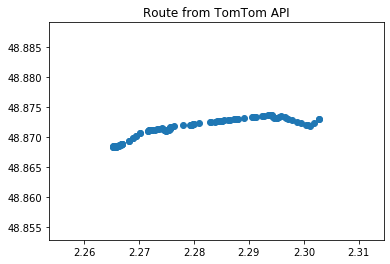

In [56]:
# Convert the points to floats    
lats = [float(x) for x in lats]
longs = [float(x) for x in longs]
# Import the plotting library
import matplotlib.pyplot as plt
plt.scatter(longs,lats)
plt.title('Route from TomTom API')
plt.show()

In [57]:
# this is the dataframe that will contain the coordinates of all the route points
column_names3 = ['Latitude', 'Longitude'] 


route_latlon = pd.DataFrame(columns=column_names3)

In [58]:
route_latlon['Latitude'] = lats
route_latlon['Longitude'] = longs

In [59]:
route_latlon.head(3)

,Latitude,Longitude
0,48.87124,2.27212
1,48.87124,2.27212
2,48.87116,2.27193


In [60]:

for lat, lon in zip(route_latlon['Latitude'],route_latlon['Longitude'] ):
    folium.CircleMarker(
    location=[lat, lon],
    radius=1,
    popup= None,
    color='#3186cc'
).add_to(map_clusters)


In [61]:
map_clusters

In [62]:
for lat, lon, poi, cluster in zip(quartiers_merged['Latitude'], quartiers_merged['Longitude'], quartiers_merged['Name'], quartiers_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
#        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### We successfully managed to find a neighborhood where to look for a new house, according to our preferences and the distance from our workplace, mission completed!

![alt text](https://upload.wikimedia.org/wikipedia/commons/e/ea/Thats_all_folks.svg "Aaaand...")